In [ ]:
#Import data from Google Drive 
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#Import Libraries 
import tensorflow as tf 
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd 
from PIL import Image
import glob
import os 
from os import listdir
from os.path import isfile, join
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns
import csv
from tabulate import tabulate

In [ ]:
data_dir_train = '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train'
data_dir_test = '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/'

## Exploratory Data Analysis

--- Data Statistics ---
-------------------------  ---
Cleavers                   287
Sugar beet                 385
Common Chickweed           611
Loose Silky-bent           654
Scentless Mayweed          516
Shepherds Purse            231
Common wheat               221
Fat Hen                    475
Small-flowered Cranesbill  496
Black-grass                263
Charlock                   390
Maize                      221
-------------------------  ---
--- Data Distribution ---


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

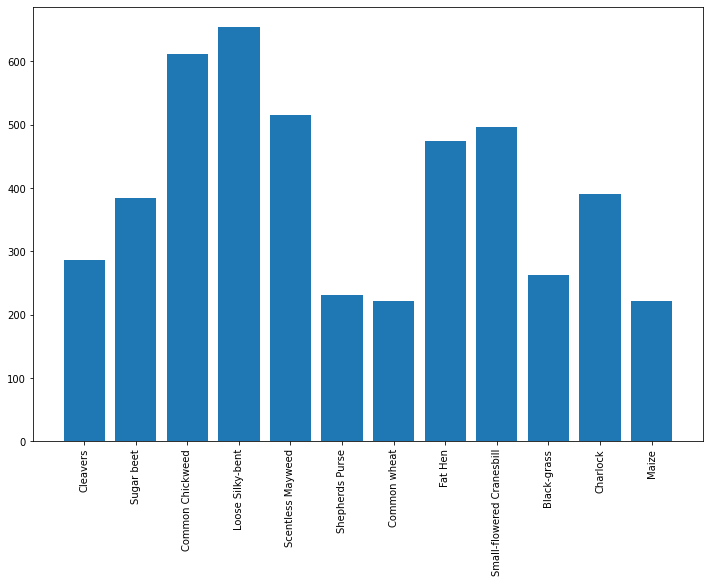

In [ ]:
all_count_list = [] #stores all the image counts
single_type_list = [] #stores all the images of each type
plant_type_list = os.listdir(data_dir_train)

for label in range(len(plant_type_list)):
  type_dir = data_dir_train + '/' + plant_type_list[label]
  plant_count = 0
  for pic in os.listdir(type_dir):
    plant_count += 1
  all_count_list.append(plant_count)

type_count_list = []
count_list = []
number_list = []
for i in range(12):
  type_count_list.append(plant_type_list[i])
  type_count_list.append(all_count_list[i])
  number_list.append(all_count_list[i])
  count_list.append(type_count_list)
  type_count_list = []

print("--- Data Statistics ---")
print(tabulate(count_list))

print("--- Data Distribution ---")
plt.figure(figsize=(12,8))
plt.bar(plant_type_list, number_list)
plt.xticks(rotation='vertical')

In [ ]:
#Oversampling 
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# ros = RandomOverSampler()
# #resample using image count and labels 
# image_ros, label_ros = ros.fit_resample()

sum = 0
for i in range(12):
  sum += number_list[i]

print(sum)

4750


## Transfer Learning

In [ ]:
#For inceptionresnetv2
batch_size = 32
img_width = 299
img_height = 299
epochs = 50

In [ ]:
#Split data 
train_image_data = ImageDataGenerator(
    validation_split = 0.2,
    rescale = 1.0/255.0,
    rotation_range = 360,
    horizontal_flip = True, 
    vertical_flip = True,
    zoom_range=0.4, 
    shear_range = 0.3,
    width_shift_range=0.3,
    height_shift_range=0.3
)

#[3803 images belonging to 12 class]
train_ds = train_image_data.flow_from_directory(
  data_dir_train,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="training")

#[947 images belonging to 12 class]
val_ds = train_image_data.flow_from_directory(
  data_dir_train,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="validation")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [ ]:
#Initialise test generator [794 images belonging to 1 class]
test_image_data = ImageDataGenerator(rescale=1./255)
test_ds = test_image_data.flow_from_directory(data_dir_test,
                                              classes = ['test'],
                                              target_size=(img_height,img_width),
                                              batch_size = 1,
                                              class_mode ='categorical',
                                              shuffle = False)

Found 794 images belonging to 1 classes.


In [ ]:
#Initialise steps per epochs
train_steps = train_ds.samples//batch_size
val_steps = val_ds.samples//batch_size
test_steps = test_ds.samples

In [ ]:
#Model 3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
base_model = InceptionResNetV2(input_shape = (img_width, img_height, 3),
                               include_top=False, weights='imagenet')
base_model.trainable = False

input_layer = tf.keras.layers.Input(shape=(img_width, img_height, 3))
x = base_model(input_layer, training=False)
max_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
dense_layer_1 = tf.keras.layers.Dense(128, activation='relu')(max_pool)
drop_layer = tf.keras.layers.Dropout(0.2)(dense_layer_1)
flat_layer = tf.keras.layers.Flatten()(drop_layer)
dense_layer_2 = tf.keras.layers.Dense(256, activation='relu')(flat_layer)
drop_layer_2 = tf.keras.layers.Dropout(0.2)(dense_layer_2)
output_layer = tf.keras.layers.Dense(12, activation='softmax')(drop_layer_2)

model = tf.keras.Model(input_layer, output_layer)
model.summary()

219070464/219055592 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 1536)       0         
 2D)                                                             
                                                                 
 dense (Dense)               (None, 4, 4, 128)         196736    
                                                                 
 dropout (Dropout)           (None, 4, 4, 128)         0         
                                                            

In [ ]:
#Compile model 
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001, epsilon=0.1, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# #Save model checkpoint
# checkpoint_filepath = './checkpoint'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

In [ ]:
#Train Model
history = model.fit(
                train_ds,
                steps_per_epoch = train_steps,
                validation_data = val_ds, 
                validation_steps = val_steps,
                epochs = epochs)

Epoch 1/50
118/118 [==============================] - 1281s 10s/step - loss: 2.7103 - accuracy: 0.1297 - val_loss: 2.3447 - val_accuracy: 0.1864
Epoch 2/50
118/118 [==============================] - 188s 2s/step - loss: 2.3701 - accuracy: 0.1811 - val_loss: 2.1526 - val_accuracy: 0.2985
Epoch 3/50
118/118 [==============================] - 186s 2s/step - loss: 2.1167 - accuracy: 0.2851 - val_loss: 1.9008 - val_accuracy: 0.3556
Epoch 4/50
118/118 [==============================] - 183s 2s/step - loss: 1.8956 - accuracy: 0.3588 - val_loss: 1.6618 - val_accuracy: 0.4623
Epoch 5/50
118/118 [==============================] - 184s 2s/step - loss: 1.6812 - accuracy: 0.4174 - val_loss: 1.4133 - val_accuracy: 0.5366
Epoch 6/50
118/118 [==============================] - 182s 2s/step - loss: 1.5321 - accuracy: 0.4537 - val_loss: 1.3776 - val_accuracy: 0.5312
Epoch 7/50
118/118 [==============================] - 184s 2s/step - loss: 1.4156 - accuracy: 0.4983 - val_loss: 1.2498 - val_accuracy: 0.57

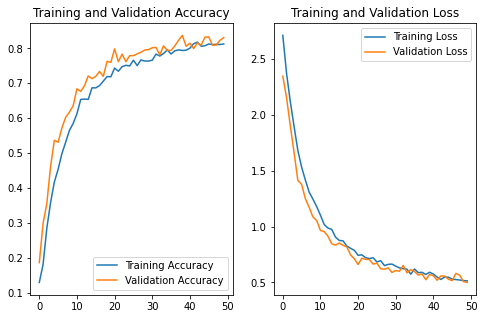

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Fine Tuning 

In [ ]:
base_model.trainable = True
opt = Adam(learning_rate=0.0001, epsilon=0.1, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 1536)       0         
 2D)                                                             
                                                                 
 dense (Dense)               (None, 4, 4, 128)         196736    
                                                                 
 dropout (Dropout)           (None, 4, 4, 128)         0         
                                                                 
 flatten (Flatten)           (None, 2048)              0     

In [ ]:
#Train Model
history_2 = model.fit(
                train_ds,
                steps_per_epoch = train_steps,
                validation_data = val_ds, 
                validation_steps = val_steps,
                epochs = 25)

Epoch 1/25
118/118 [==============================] - 370s 3s/step - loss: 0.4553 - accuracy: 0.8290 - val_loss: 0.4721 - val_accuracy: 0.8534
Epoch 2/25
118/118 [==============================] - 334s 3s/step - loss: 0.4039 - accuracy: 0.8507 - val_loss: 0.3983 - val_accuracy: 0.8675
Epoch 3/25
118/118 [==============================] - 334s 3s/step - loss: 0.3640 - accuracy: 0.8671 - val_loss: 0.4152 - val_accuracy: 0.8685
Epoch 4/25
118/118 [==============================] - 335s 3s/step - loss: 0.3505 - accuracy: 0.8767 - val_loss: 0.4072 - val_accuracy: 0.8664
Epoch 5/25
118/118 [==============================] - 335s 3s/step - loss: 0.3206 - accuracy: 0.8849 - val_loss: 0.3973 - val_accuracy: 0.8912
Epoch 6/25
118/118 [==============================] - 334s 3s/step - loss: 0.2949 - accuracy: 0.8881 - val_loss: 0.3655 - val_accuracy: 0.8750
Epoch 7/25
118/118 [==============================] - 335s 3s/step - loss: 0.2790 - accuracy: 0.8955 - val_loss: 0.3550 - val_accuracy: 0.8847

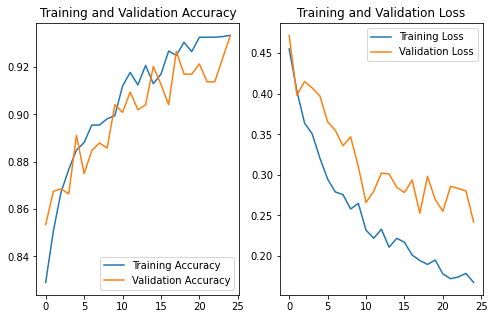

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = 25
epochs_range = range(epochs)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(checkpoint_filepath)

In [ ]:
#Evaluate model with test dataset 
model.evaluate_generator(val_ds, steps=val_steps, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


29/29 [==============================] - 39s 1s/step - loss: 0.2603 - accuracy: 0.9300


[0.2602689862251282, 0.9299569129943848]

In [ ]:
#Predict test values 
test_ds.reset() #maintain test order
test_predictions = model.predict_generator(test_ds, test_steps, verbose=1 )

794/794 [==============================] - 179s 219ms/step


In [ ]:
import numpy as np
predicted_plant_type = np.argmax(test_predictions, axis=1)

In [ ]:
labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_plant_type]

In [ ]:
test_pred = []
filenames=test_ds.filenames
for name in range(len(filenames)):
    test_pred.append(filenames[name].split('/')[1])

results=pd.DataFrame({"file":test_pred,
                      "species":predictions})
results.to_csv("submission.csv",index=False)